In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models import *
plt.style.use('ggplot')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report

In [3]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [4]:
fake_df['truth'] = 0
true_df['truth'] = 1
true_df['text'] = true_df['text'].apply(clean_text)
all_news_df = pd.concat([fake_df, true_df])
all_news_df['title'] = all_news_df['title'].apply(clean_titles)

In [5]:
def get_X_y_splits(df, X_col, y_col='truth'):
    ''' Takes a dataframe and returns a train test split for labeled data.
    Input: DataFrame, X column name (string), target column name (string).
    Ouput: X_train, X_test, y_train, y_test'''
    X = df[X_col].values
    y = df[y_col].values
    return train_test_split(X, y)

In [6]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'title')

In [7]:
baseline_clf = baseline_model(X_train, y_train)

/home/kellen/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [8]:
nb_clf = naive_bayes_model(X_train,y_train)

In [9]:
nb_predicted = nb_clf.predict(X_test)
nb_clf.score(X_test, y_test)

0.9387973273942094

In [10]:
sgd_clf = stochastic_gradient_descent_model(X_train,y_train)

In [11]:
sgd_predicted = sgd_clf.predict(X_test)
sgd_clf.score(X_test, y_test)

0.9397772828507795

In [12]:
pa_clf = passive_aggressive_model(X_train,y_train)

In [13]:

pa_clf_predicted = pa_clf.predict(X_test)
pa_clf.score(X_test, y_test)

0.9541202672605791

In [14]:
coefs = pa_clf.best_estimator_.named_steps.clf.coef_
bag = pa_clf.best_estimator_.named_steps.vect.get_feature_names()

In [15]:
freq_df = pd.DataFrame(index=bag, data={'coefs': coefs[0]})
freq_df = freq_df.iloc[(-freq_df['coefs'].abs()).argsort()]
freq_df.head()

,coefs
video,-12.964436
hillary,-8.240148
breaking,-8.066084
gop,-7.734201
just,-7.701761


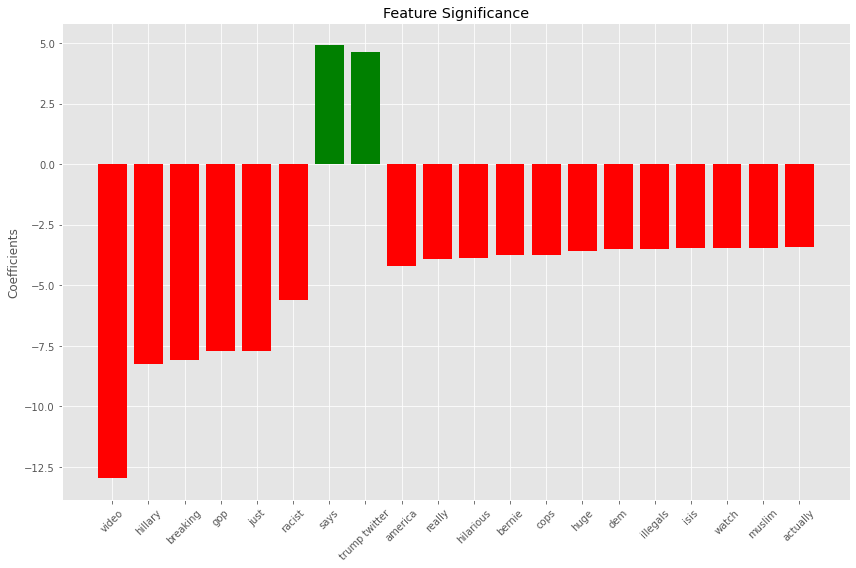

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(freq_df.index[:20], freq_df['coefs'][:20].values, color=(freq_df['coefs'][:20] > 0).map({True:'green',False:'red'}))
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Feature Significance')
ax.set_ylabel('Coefficients')
# fig.savefig('images/feature_correlation')
fig.tight_layout()

(0.0, 0.2)

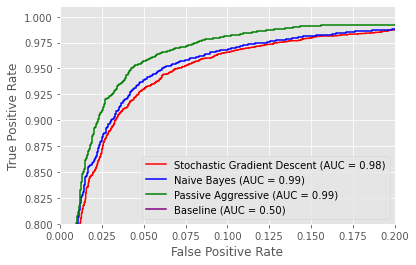

In [24]:
fig, ax = plt.subplots()
plot_roc_curve(sgd_clf, X_test, y_test, name='Stochastic Gradient Descent', ax=ax, color='red')
plot_roc_curve(nb_clf, X_test, y_test, name='Naive Bayes', ax=ax, color='blue')
plot_roc_curve(pa_clf, X_test, y_test, name='Passive Aggressive', ax=ax, color='green')
plot_roc_curve(baseline_clf, X_test, y_test, name='Baseline', ax=ax, color='purple')
ax.set_ylim(.8,1.01)
ax.set_xlim(0,.2)

In [18]:
confusion_matrix(y_test, nb_predicted)

array([[5718,  198],
       [ 489, 4820]])

In [19]:
confusion_matrix(y_test, sgd_predicted)

array([[5568,  348],
       [ 328, 4981]])

In [20]:
confusion_matrix(y_test, pa_clf_predicted)

array([[5663,  253],
       [ 262, 5047]])

In [21]:
print(classification_report(y_test, sgd_predicted, target_names=['Fake News','Real News']))

              precision    recall  f1-score   support

   Fake News       0.94      0.94      0.94      5916
   Real News       0.93      0.94      0.94      5309

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [22]:
test_title = ["Protesters ignite fury after shutting down packed Florida highway"]
pa_clf.predict(test_title)

array([0])